## Load Dataset

In [1]:
import torchvision as thv
import os
import pickle
from torch.utils.data import Subset
import numpy as np

def get_mnist_dataset(root='./mnist_data'):
    # Check if the dataset already exists locally
    if os.path.exists(f'{root}/train_data.pkl') and os.path.exists(f'{root}/val_data.pkl'):
        print("Loading MNIST dataset from local storage...")
        with open(f'{root}/train_data.pkl', 'rb') as f:
            train = pickle.load(f)
        with open(f'{root}/val_data.pkl', 'rb') as f:
            val = pickle.load(f)
    else:
        print("Downloading MNIST dataset...")
        # Download the dataset
        train = thv.datasets.MNIST(root, download=True, train=True)
        val = thv.datasets.MNIST(root, download=True, train=False)
        
        # Save the dataset locally
        os.makedirs(root, exist_ok=True)
        with open(f'{root}/train_data.pkl', 'wb') as f:
            pickle.dump(train, f)
        with open(f'{root}/val_data.pkl', 'wb') as f:
            pickle.dump(val, f)

    print(f"Training dataset shape: {train.data.shape}, Number of targets: {len(train.targets)}")
    print(f"Validation dataset shape: {val.data.shape}, Number of targets: {len(val.targets)}")

    return train, val
    
def split_dataset(train, val):
    import torch
    import numpy as np
    from torch.utils.data import Subset

    # Define the number of classes and target sizes
    num_classes = 10
    target_train_size = 30000
    target_val_size = 5000

    # Initialize lists to hold the indices for the refined datasets
    train_indices = []
    val_indices = []

    # Iterate over each class and collect indices for the split
    for i in range(num_classes):
        # Get indices of all examples from class i in the training and validation sets
        train_class_indices = (train.targets == i).nonzero(as_tuple=True)[0]
        val_class_indices = (val.targets == i).nonzero(as_tuple=True)[0]

        # Convert indices to numpy arrays for shuffling
        train_class_indices_np = train_class_indices.numpy()
        val_class_indices_np = val_class_indices.numpy()

        # Shuffle indices
        np.random.shuffle(train_class_indices_np)
        np.random.shuffle(val_class_indices_np)

        # Calculate split indices, initially aiming to round up
        split_idx_train = (len(train_class_indices_np) + 1) // 2
        split_idx_val = (len(val_class_indices_np) + 1) // 2

        # Adjust split to avoid exceeding overall target sizes
        if len(train_indices) + split_idx_train > target_train_size:
            split_idx_train = target_train_size - len(train_indices)
        if len(val_indices) + split_idx_val > target_val_size:
            split_idx_val = target_val_size - len(val_indices)

        # Add indices to lists
        train_indices.extend(train_class_indices_np[:split_idx_train])
        val_indices.extend(val_class_indices_np[:split_idx_val])

        # Check if we have already reached the target sizes
        if len(train_indices) == target_train_size and len(val_indices) == target_val_size:
            break

    # Create refined datasets
    refined_train = Subset(train, train_indices)
    refined_val = Subset(val, val_indices)

    print(f"Refined training dataset size: {len(refined_train)}")
    print(f"Refined validation dataset size: {len(refined_val)}")

    return refined_train, refined_val

In [2]:
data_path = "./prob3_mnist_data"

train, val = get_mnist_dataset(data_path)
refined_train, refined_val = split_dataset(train, val)

print("Train", train)
print("Val", val)
print("Refined Train", refined_train)
print("Refined Val", refined_val)

Loading MNIST dataset from local storage...
Training dataset shape: torch.Size([60000, 28, 28]), Number of targets: 60000
Validation dataset shape: torch.Size([10000, 28, 28]), Number of targets: 10000
Refined training dataset size: 30000
Refined validation dataset size: 5000
Train Dataset MNIST
    Number of datapoints: 60000
    Root location: ./prob3_mnist_data
    Split: Train
Val Dataset MNIST
    Number of datapoints: 10000
    Root location: ./prob3_mnist_data
    Split: Test
Refined Train <torch.utils.data.dataset.Subset object at 0x000002040BBE1070>
Refined Val <torch.utils.data.dataset.Subset object at 0x000002040BBE1040>


## Plot and Validate Dataset

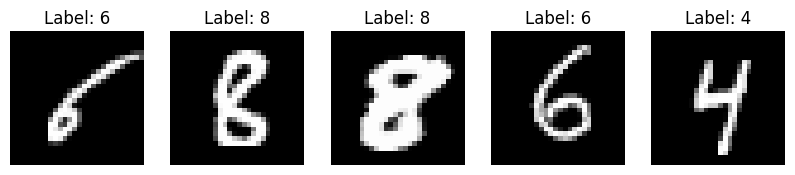

In [3]:
import matplotlib.pyplot as plt
import torch

def plot_images(dataset, num_images=6):
    # Making sure the dataset can be indexed directly
    assert hasattr(dataset, '__getitem__'), "Dataset must support indexing"

    indices = np.random.choice(len(dataset), num_images, replace=False)

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 3))
    
    if num_images == 1:
        axes = [axes]
    
    for ax, idx in zip(axes, indices):
        image, label = dataset[idx]
        
        # MNIST images are 1-channel images, need to be reshaped if in tensor form
        if isinstance(image, torch.Tensor):
            image = image.numpy().squeeze()  # Convert to numpy and remove extra dimensions
        
        ax.imshow(image, cmap='gray')
        ax.set_title(f"Label: {label}")
        ax.axis('off')

    plt.show()

plot_images(refined_train, num_images=5)

## Linear Layer

### Forward function
For $\beta$ samples, $\alpha$ input features, and $c$ output features, the forward function is 
$$h^{(l+1)} = h^{(l)} W^{\top} + b$$
where: $h^l \in R^{\beta \times \alpha}$, $W \in R^{c \times \alpha}$, $b \in R^c$, $h^{l+1} \in R^{\beta \times c}$

### Backward function:
$$\frac{\partial L}{\partial h^l} = \frac{\partial L}{\partial h^{l+1}} W$$
$$\frac{\partial L}{\partial W} = \frac{\partial L}{\partial h^{l+1}}^{\top} h^l$$
$$\frac{\partial L}{\partial b} = \sum_{i=1}^\beta \frac{\partial L}{\partial h_i^{l+1}}$$
where: $\frac{\partial L}{\partial h^{l+1}} \in R^{\beta \times c}$, $\frac{\partial L}{\partial W} \in R^{c \times \alpha}$, $\frac{\partial L}{\partial b} \in R^c$



In [4]:
from layers import linear_t


## ReLU Layer

### Forward function
$$h^{(l+1)} = \max(0, h^{(l)})$$
where: $h^l \in R^{\beta \times \alpha}$, $h^{(l+1)} \in R^{\beta \times \alpha}$

### Backward function
$$\frac{\partial L}{\partial h^l} = \frac{\partial L}{\partial h^{l+1}} \odot \mathbb{1}(h^l > 0)$$
where: $\odot$ is element-wise multiplication, $\mathbb{1}$ is the indicator function

In [5]:
from layers import relu_t

## Combined Softmax and Cross-entropy Loss Layer

### Forward function
$$h_k^{(l+1)} = \frac{e^{h_k^{(l)}}}{\sum_{k'} e^{h_{k'}^{(l)}}}$$
$$l(y) = -\log(h_y^{(l+1)})$$
For a mini-batch of size $\beta$, the loss is
$$l({y_i}_{i=1,...,\beta}) = -\frac{1}{\beta} \sum_{i=1}^{\beta} \log(h_y^{(l+1)})$$

Error is
$$\text{error} = \frac{1}{\beta} \sum_{i=1}^{\beta} \mathbb{1}(y \neq \text{argmax}_k(h_k^{(l+1)}))$$

### Backward function
$$\frac{\partial L}{\partial h^{(l)}} = \frac{1}{\beta} \sum_{i=1}^{\beta} \frac{\partial l(y_i)}{\partial h^{(l)}}$$
where: $\frac{\partial l(y_i)}{\partial h^{(l)}} = h^{(l+1)} - \mathbb{1}(y_i)$


In [6]:
from layers import softmax_cross_entropy_t

## Check the backward pass of all three layers

In [7]:
from layers import linear_t

lin = linear_t(alpha=3, c=4)
h_l = np.array([[0.5, 1.5, 2.5], [-0.5, -1.5, -2.5]])  # alpha = 3, beta = 2
dh_lp1 = np.array([[0.1, 1, 2, 10], [0.1, 1, 2, 10]])  # c = 4, beta = 2
lin.W = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])  # c = 4, alpha = 3

h_lp1 = lin.forward(h_l)
lin.zero_grad()
dh_l = lin.backward(dh_lp1)

print(h_lp1)
print(dh_l)
print(lin.dW)
print(lin.db)

[[ 11.30988871  24.99237965  37.53063319  52.16424849]
 [-10.69011129 -24.00762035 -38.46936681 -50.83575151]]
[[118.1 131.2 144.3]
 [118.1 131.2 144.3]]
[[  0.05   0.15   0.25  -0.05  -0.15  -0.25]
 [  0.5    1.5    2.5   -0.5   -1.5   -2.5 ]
 [  1.     3.     5.    -1.    -3.    -5.  ]
 [  5.    15.    25.    -5.   -15.   -25.  ]
 [  0.05   0.15   0.25  -0.05  -0.15  -0.25]
 [  0.5    1.5    2.5   -0.5   -1.5   -2.5 ]
 [  1.     3.     5.    -1.    -3.    -5.  ]
 [  5.    15.    25.    -5.   -15.   -25.  ]]
[ 0.2  2.   4.  20. ]


In [8]:
from layers import relu_t

relu = relu_t()
h_l = np.array([[0.5, 1.5, -2.5], [0.5, -1.5, 2.5]])  # alpha = 3, beta = 2
dh_lp1 = np.array([[0.3, 2, 1], [-1, -1, -1]])  

h_lp1 = relu.forward(h_l)
dh_l = relu.backward(dh_lp1)

print(h_lp1)
print(dh_l)

[[0.5 1.5 0. ]
 [0.5 0.  2.5]]
[[ 0.3  2.   0. ]
 [-1.  -0.  -1. ]]


In [10]:
from layers import softmax_cross_entropy_t
import torch
import torch.nn.functional as F

# Single sample
sce = softmax_cross_entropy_t()
h_l = np.array([1, 2, 3])
y = np.array([2])
dh_lp1 = np.array([0.1, 1, 2])

h_lp1, ell, error = sce.forward(h_l, y)
dh_l = sce.backward(dh_lp1, y)

print("\nSingle sample")
print(h_lp1)
print(ell)
print(error)
print(dh_l)

# Batched samples
sce = softmax_cross_entropy_t()
h_l = np.array([[1, 2, 3], [2, -1, 3]])
y = np.array([2, 1])
dh_lp1 = np.array([[0.1, 1, 2], [0.1, 1, 2]])

h_lp1, ell, error = sce.forward(h_l, y)
dh_l = sce.backward(dh_lp1, y)

print("\nBatched")
print(h_lp1)
print(ell)
print(error)
print(dh_l)


Single sample
[[0.09003057 0.24472847 0.66524096]]
0.4076059644443803
0.0
[[ 0.09003057  0.24472847 -0.33475904]]

Batched
[[0.09003057 0.24472847 0.66524096]
 [0.26538793 0.01321289 0.72139918]]
2.3670843028559254
0.5
[[ 0.04501529  0.12236424 -0.16737952]
 [ 0.13269396 -0.49339356  0.36069959]]


### Since all three layers have been validated and compared with PyTorch, we can continue to (f)

## Training

In [ ]:
# Load dataset
...

# Initialize all the layers
l1, l2, l3 = linear_t(), relu_t(), softmax_cross_entropy_t()
net = [l1, l2, l3]

lr = 0.1

# Train for at least 1000 iterations
import tqdm
for t in tqdm.tqdm(range(1000)):
    # 1. Sample a mini-batch of size = 32
    # Each image in the mini-batch is chosen uniformly randomly from the training dataset
    x, y = ...
    
    # 2. Zero gradient buffer
    for l in net:
        l.zero_grad()
    
    # 3. Forward pass
    h1 = l1.forward(x)
    h2 = l2.forward(h1)
    ell, error = l3.forward(h2, y)
    
    # 4. Backward pass
    dh2 = l3.backward()
    dh1 = l2.backward(dh2)
    dx = l1.backward(dh1)
    
    # 5. Gather backprop gradients
    dW, db = l1.dW, l1.db
    
    # 6. Print some quantities for logging and debugging
    print(t, ell, error)
    print(t, np.linalg.norm(dW/l1.W), np.linalg.norm(db/l1.b))
    
    # 7. One step of SGD
    l1.W = l1.W - lr * dW
    l1.b = l1.b - lr * db